In [15]:
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np

In [16]:
df = pd.read_csv('../debate_dataset.csv')
df.head()

,comment_id,post_id,debate_group,comment_user_name,commented_user_name,comment_body,comment_score
0,kxtjk7w,1bulhj9,1,T_JaM_T,theenkos,"No, la quantità di acqua che cade sotto forma ...",18
1,kxub8sy,1bulhj9,1,T_JaM_T,CosmoTwoFins,L'avevo sentito due o tre mesi fa in una trasm...,1
2,kxww2q1,1bulhj9,1,_The_Prov_,lore_mila_,L'unica a inquinare meno pro capite rispetto a...,2
3,kxuegzt,1bulhj9,1,_The_Prov_,Reforged_Narsil,"Si, chiedo scusa, il mio dato si riferiva solo...",2
4,kxtgmx2,1bulhj9,2,davidevernizzi,Dangerous-Practice-6,"Senza sarcasmo o polemica, cosa? Per come la v...",4


In [17]:
post_id_dict = {}
dataframe_list = []
for post_id in df['post_id'].unique():
    dataframe = df[df['post_id'] == post_id]
    dataframe_list.append(dataframe)
    post_id_dict[post_id] = dataframe

In [18]:
def create_graph_from_dataframe(dataframe):
    graph = ig.Graph(directed=True)
    graph.add_vertex(name='root', label='root')
    for comment in dataframe.iterrows():
        if comment[1]['comment_user_name'] not in graph.vs['name']:
            graph.add_vertex(name=comment[1]['comment_user_name'], label=comment[1]['comment_user_name'])
        if comment[1]['commented_user_name'] not in graph.vs['name']:
            graph.add_vertex(name=comment[1]['commented_user_name'], label=comment[1]['commented_user_name'])
        graph.add_edge(comment[1]['comment_user_name'], comment[1]['commented_user_name'])
    
    graph.delete_vertices('root')
    return graph

post_graph = []
for dataframe in dataframe_list:
    post_graph.append(create_graph_from_dataframe(dataframe))

# Metriche di valutazione dei grafi di dibattitio

## Metriche sul POST

### Calcolo dell' average degree
Calcolando l'average degree di ciascun post, è possibile farsi un'idea generale di quanto gli utenti tendono ad interagire tra di loro 

In [19]:
def degree_distribution(graph):
    degree = graph.degree()
    n = graph.vcount()
    degree = np.array(degree)

    return 1/n * sum(degree)

print(degree_distribution(graph))

NameError: name 'graph' is not defined

### Distribuzione dei gradi
Questo grafico ci permette di osservare la distribuzione dei gradi di ogni nodo all'interno del grafo, offrendo una visione chiara del livello di interazione degli utenti. **Qual è la percentuale di utenti che hanno interagito poco/tanto con il post?**

In [20]:

def compute_degree_distribution(graph):
    degree = graph.degree()
    x_label = np.unique(degree)
    degree = np.array(degree)
    y = []
    for i in x_label:
        y.append(sum(degree == i)/ len(degree)) 
    plt.scatter(x_label, y)
    plt.xlabel('Degree')
    plt.ylabel('Number of nodes')
    plt.title('Degree distribution')
    plt.show()

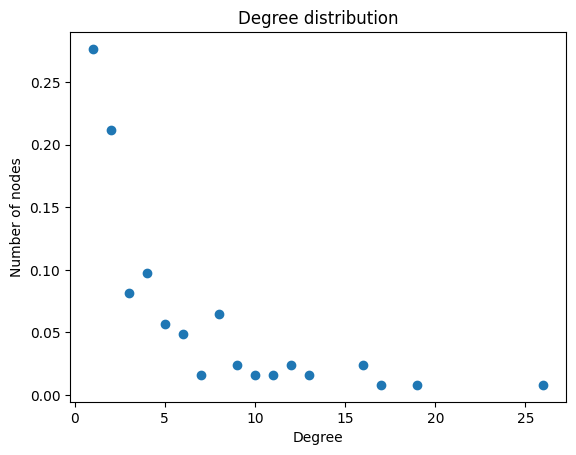

4.504065040650407


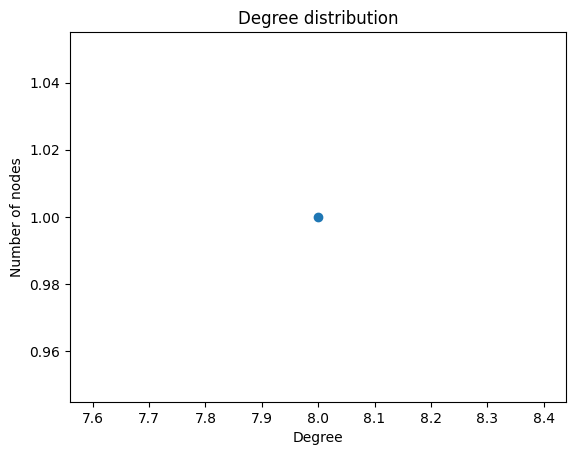

8.0


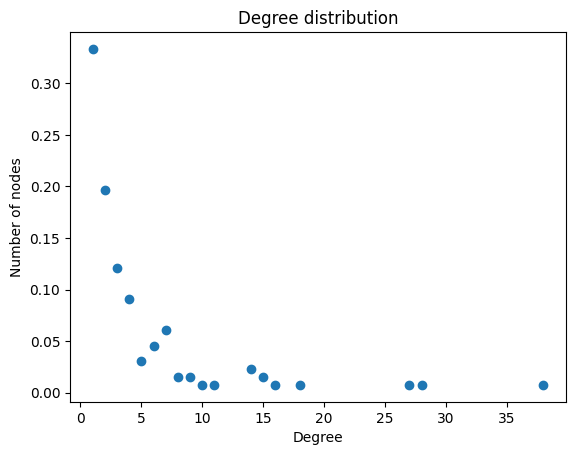

4.2272727272727275


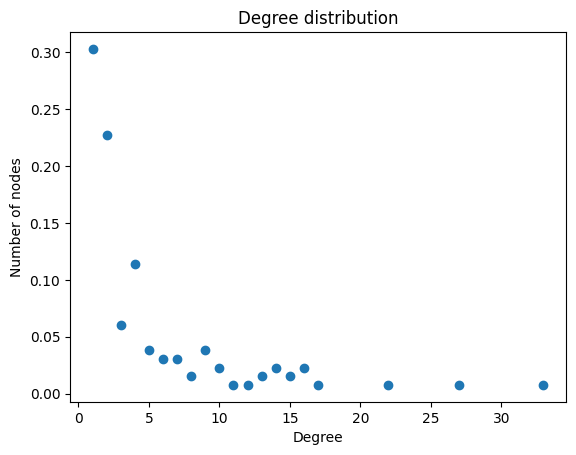

4.696969696969697


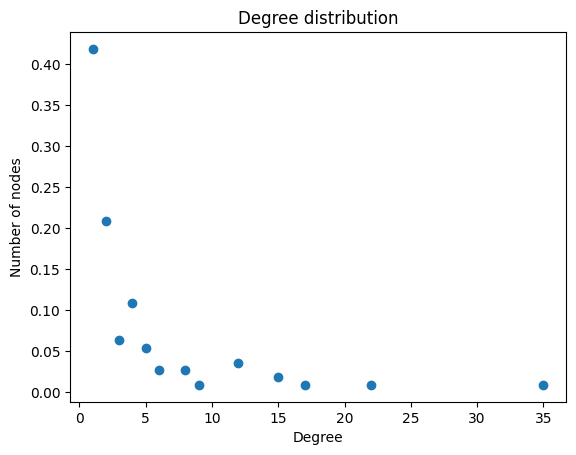

3.5818181818181816


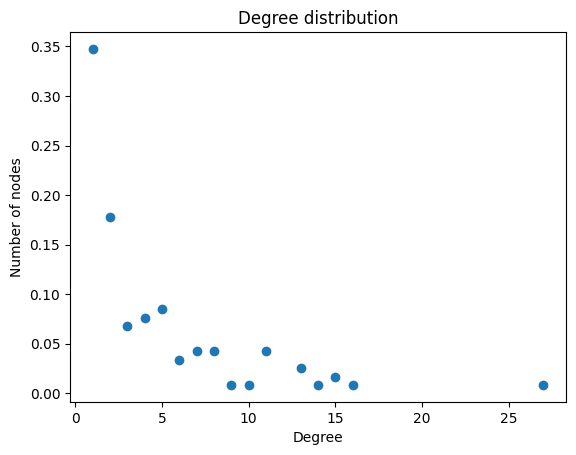

4.169491525423728


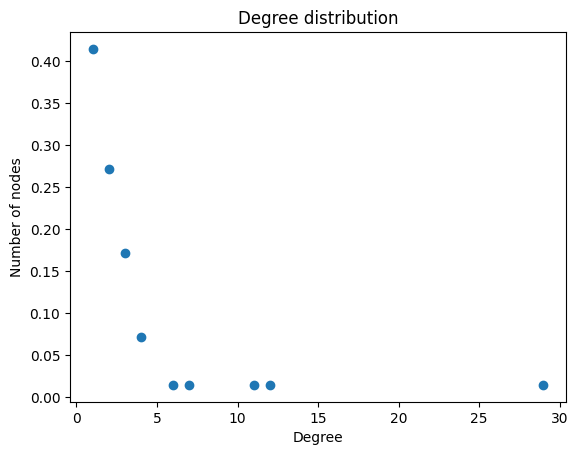

2.6857142857142855


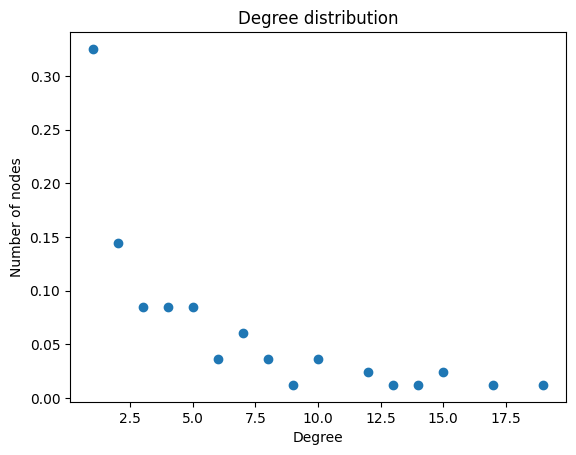

4.433734939759036


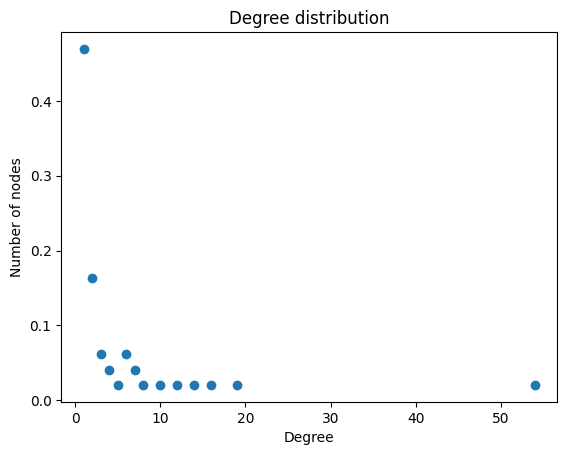

4.612244897959183


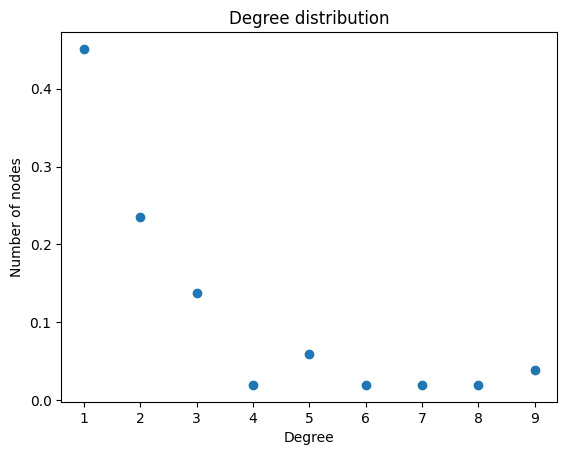

2.4705882352941178


In [21]:
for post_graph in post_graph:
    compute_degree_distribution(post_graph)
    print(degree_distribution(post_graph))

## Metriche sul Dibattito

### Coefficiente di clustering medio
Tramite il coefficiente di clustring medio possiamo ottenere una misura golbale del grado di coesione degli utenti all'interno della dibattito, ovvero quanto gli utenti hanno interagito tra di loro all'interno della discussione in questione.

In [ ]:
def compute_average_clustering_coefficient(graph):
    return graph.transitivity_undirected()

print(compute_average_clustering_coefficient(graph))

0.04659270998415214
